In [1]:
import torch.nn as nn
import torch.nn.functional as F
import math
from torchsummary import summary


def conv3x3(inchannel, outchannel, stride=1):
    "3x3 convoulution with padding"
    return nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False)
# 残差块
class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, inchannel, outchannel, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(inchannel, outchannel, stride)
        self.bn1 = nn.BatchNorm2d(outchannel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(outchannel, outchannel)
        self.bn2 = nn.BatchNorm2d(outchannel)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # 把shortcut那的channel的维度统一
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        self.inchannel = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512*block.expansion, num_classes)

       
                
    def _make_layer(self, block, outchannel, blocks, stride=1):
        # downsample主要用来处理H(x)=F(x)+x中F(x)和x的channel维度不匹配的问题
        downsample = None
        # self.inchannel为上个box_block的输出channel， outchannel为当前box_block块的输入channel
        if stride != 1 or self.inchannel != outchannel*block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inchannel, outchannel*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel*block.expansion),
            )
        
        layers = []
        layers.append(block(self.inchannel, outchannel, stride, downsample))
        self.inchannel = outchannel*block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inchannel, outchannel))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
def resnet18():
    #[2, 2, 2, 2]和结构图[]x2是对应的
    model = ResNet(ResidualBlock, [2, 2, 2, 2])
    return model

#model = resnet18()
#print(model)
#print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")
#model = model.to('cuda')
#summary(model, input_size=(3, 128, 128), batch_size=-1, device='cuda')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
from tqdm import tqdm
from torch.utils.data import DataLoader, dataloader, Subset
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from sklearn.model_selection import KFold

from torch.utils.tensorboard import SummaryWriter
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 超参数设置
EPOCH = 30  # 遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 64  # 批处理尺寸(batch_size)
LR = 0.001  # 学习率
val_accuracies = []


# 图像预处理
transform_train = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),  # 图像一半的概率翻转，一半的概率不翻转
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # R,G,B每层的归一化用到的均值和方差
])

transform_valid = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# 训练数据集
train_dataset = ImageFolder(root='../input/corn/train/', transform=transform_train)  


num_train = int(len(train_dataset))



# 定义K-fold对象
Kf_train = KFold(n_splits=5, shuffle=True, random_state=42)


print("数据集加载完毕!")

print("开始resnet网络模型初始化!")
# 模型定义-ResNet
model = resnet18().to(device)

# 定义损失函数和优化方式
loss_fn = nn.CrossEntropyLoss()  # 损失函数为交叉熵，多用于多分类问题
loss_fn = loss_fn.to(device)
# 优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
optimizer = optim.SGD(model.parameters(),lr=LR, momentum=0.9, weight_decay=5e-4)  

# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0
# 记录训练集和测试集的正确率，形成列表
total_test_acc_list = []
total_test_loss_list = []
total_train_loss_list = []
total_train_acc_list = []

# 添加tensorboard画图可视化
writer = SummaryWriter("../resnet18/logs_train_kfold")

print("resnet网络模型初始化完毕!")
# 训练
if __name__ == "__main__":
    best_acc = 80  # 2 初始化best test accuracy
    best_epoch = 0
    # 有需要可以打开，接着上次训练好的权重训练
    print("加载模型...")
    #with open("../resnet18/epoch_corn/resnet18_20.pth",'rb') as f:
    #     model.load_state_dict(torch.load(f))
    print("加载完毕!")
    print("开始训练! resnet18! 冲!")  # 定义遍历数据集的次数

    for train_index, val_index in Kf_train.split(range(num_train)):
        train_kfold_subset = Subset(train_dataset, train_index)
        val_kfold_subset =Subset(train_dataset, val_index)

        trainloader = DataLoader(train_kfold_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        validloader = DataLoader(val_kfold_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

        for epoch in range(pre_epoch, EPOCH):
            model.train()
            print(f'--------第{epoch + 1}轮训练开始---------')
            total_train_loss = 0.0
            correct = 0.0
            total = 0.0
            for data in tqdm(trainloader):
            # print("-------",i)
            # 准备数据
               inputs, labels = data
               inputs, labels = inputs.to(device), labels.to(device)
            #梯度清零
               optimizer.zero_grad()

            # forward + backward
            # 前向传播获取网络输出信息，做损失函数的输出计算，后向传播获取梯度信息，根据学习策略优化学习
               outputs = model(inputs)
               loss = loss_fn(outputs, labels)
               loss.backward()
               optimizer.step()

            # 每训练100个batch打印一次loss和准确率
               total_train_loss += loss.item()
               _, predicted = torch.max(outputs.data, 1)
               total += labels.size(0)
               total_train_step += 1
               correct += predicted.eq(labels.data).cpu().sum()
    
               writer.add_scalar("train_loss", loss.item(), total_train_step)
            train_accurary = 100 * correct / total
            print(f'训练集正确率为:{train_accurary}')
            total_train_acc_list.append(train_accurary)
            total_train_loss_list.append(total_train_loss)


            # 每训练完一个epoch测试一下准确率
            print("开始测试!")
            model.eval()
            with torch.no_grad():
               correct = 0
               total = 0
               total_test_loss=0
               for data in tqdm(validloader):
                
                   images, labels = data
                   images, labels = images.to(device), labels.to(device)
                   outputs = model(images)
                   loss = loss_fn(outputs, labels)
                   total_test_loss += loss.item()
                # 取得分最高的那个类 (outputs.data的索引号)
                   _, predicted = torch.max(outputs.data, 1)
                # labels是一个尺寸为 的张量[N, 1]，其中N等于批次中的样本数。
                   total += labels.size(0)
                   correct += (predicted == labels).sum().item()
                # result = torch.floor_divide(correct, total)
            # print('测试分类准确率为：%.3f%%' % (100 * result))
               acc = 100 * correct / total
               print(f"测试集上的loss：{total_test_loss}")
               print(f'测试分类准确率为：{acc}')
           
            # 将每次测试结果实时写入acc.txt文件中
               print('Saving model......')
               torch.save(model.state_dict(), f'../resnet18/epoch_corn/resnet18_5fold{epoch + 1}(corn).pth')
               writer.add_scalar("test_loss", total_test_loss, total_test_step)
               total_test_step = total_test_step + 1
               total_test_acc_list.append(acc)
               total_test_loss_list.append(total_test_loss)
            # 记录最佳测试分类准确率并写入best_acc.txt文件中
               if acc > best_acc:
                   f3 = open("../resnet18/5fold_acc2(corn).txt", "w")
                   f3.write(f"训练轮次为{epoch + 1}时,准确率最高!准确率为{acc}")
                   f3.close()
                   best_acc = acc
            val_accuracies.append(best_acc)
        print("训练结束!")

average_val_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f"Average Validation Accuracy: {average_val_accuracy:.4f}")

for i in range(len(total_test_acc_list)):
    with open('../resnet18/resnet18_5fold_acc(corn).txt', 'a') as f:
        f.write('%d %.5f %.5f %.5f %.5f\n' % (i+1,total_train_acc_list[i],total_train_loss_list[i],total_test_acc_list[i],total_test_loss_list[i]))
#     with open('skip18_train_accura/te_records_k.txt', 'a') as f:
#         f.write('%d %.3f\n' % (i+1,total_train_accuracy_list[i]))
torch.save(model.state_dict(),"../resnet18/resnet18_acc_5fold_corn.pkl")



seed is 121
cuda


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

score_array: (1195, 5)
label_onehot: (1195, 5)
(1196,) (1196,) 0.9961027565464462
(1196,) (1196,) 0.9999304096714642
(1196,) (1196,) 0.999638259767885
(1196,) (1196,) 0.997043025695924
(1196,) (1196,) 0.9985117028703258
Average precision score, micro-averaged over all classes: 0.9979
Accuracy of bluegrass : 99.163 %
Accuracy of chenopodium album : 99.163 %
Accuracy of cirsium setosum : 99.582 %
Accuracy of  corn : 99.163 %
Accuracy of sedge : 98.326 %
[[237   1   1   0   0]
 [  2 237   0   0   0]
 [  0   0 238   0   1]
 [  0   0   0 237   2]
 [  1   0   0   3 235]]


<Figure size 640x480 with 0 Axes>

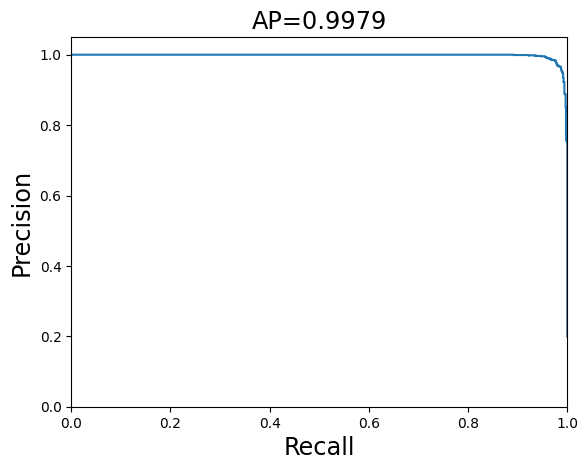

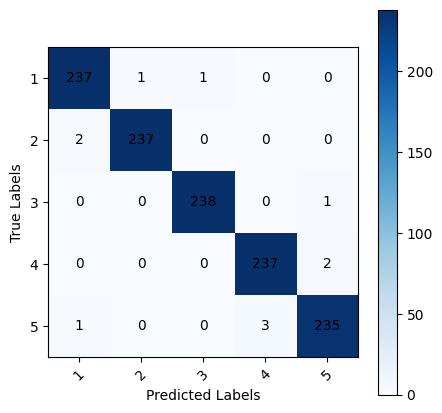

In [2]:
# 使用cifar10数据集，跳跃网络

from numpy import log2
import torch
import torch.nn.functional as F
from torch.nn.modules import flatten
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.pooling import MaxPool2d
import torchvision
from torch.utils.data import DataLoader, dataloader
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import torch.optim as optim
from torchvision.datasets import ImageFolder
import os
import random
from sklearn.metrics import roc_curve, auc, f1_score,precision_recall_curve,average_precision_score

# import seaborn as sns
# from resnet_skip import ResNet_Skip
seed_n = 121
print('seed is ' + str(seed_n))
g = torch.Generator()
g.manual_seed(seed_n)
random.seed(seed_n)
np.random.seed(seed_n)
torch.manual_seed(seed_n)
torch.cuda.manual_seed(seed_n)
torch.cuda.manual_seed_all(seed_n)
            # torch.backends.cudnn.deterministic=True
            # torch.backends.cudnn.benchmark = False
            # torch.backends.cudnn.enabled = False
            # torch.use_deterministic_algorithms(True)
            # os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['PYTHONHASHSEED'] = str(seed_n)  # 为了禁止hash随机化，使得实验可复现。



transform_test = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])



# 测试训练集
testset = ImageFolder(root='../input/corn/test/', transform=transform_test )
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, num_workers=0)



#数据集长度
test_data_size = len(testset)


num_classes = 5
# 存储预测得分
score_list = []
# 存储真实标签
label_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


test_net = resnet18()

test_net.load_state_dict(torch.load("../resnet18/resnet18_acc_5fold_corn.pkl"))

test_net.to(device)
#创建损失函数
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn.to(device)
#创建优化器
learning_rata = 0.001

optimizer = optim.SGD(test_net.parameters(),lr=learning_rata, momentum=0.9, weight_decay=5e-4)


plt.figure()

#训练的次数
total_train_step = 0
#测试次数
total_test_step = 0
total_train_accuracy = 0
# Decey_x = 0.5
total_train_accuracy_list = []
total_test_accuracy_list = []

total_accuracy = 0
#测试步骤
test_net.eval()
total_test_loss = 0
total_test_step = 0
# 测试模型
correct = [0] * 5
total = [0] * 5
y_pred = []
y_true = []
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images = images.to(device)
       
        labels = labels.to(device)

        outputs = test_net(images)
        score_temp = outputs
        score_list.extend(score_temp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())

        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())
        for i in range(len(labels)):
            label = labels[i]
            total[label] += 1
            if predicted[i] == label:
                correct[label] += 1

    score_array = np.array(score_list)
    # 将label转换为onehot形式
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0],1))
    label_onehot = torch.zeros(label_tensor.shape[0], num_classes)
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)
    print("score_array:", score_array.shape)
    print("label_onehot:", label_onehot.shape)

    #调用sklearn库，计算每个类别对应的precision和recall
    precision_dict = dict()
    recall_dict = dict()
    average_precision_dict = dict()
    for i in range(num_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(label_onehot[:, i], score_array[:, i])
        average_precision_dict[i] = average_precision_score(label_onehot[:, i], score_array[:, i])
        print(precision_dict[i].shape, recall_dict[i].shape, average_precision_dict[i])

    # micro
    precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(label_onehot.ravel(),
                                                                              score_array.ravel())
    average_precision_dict["micro"] = average_precision_score(label_onehot, score_array, average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.4f}'.format(average_precision_dict["micro"]))
 
    # 绘制所有类别平均的pr曲线
    plt.figure()
    plt.step(recall_dict['micro'], precision_dict['micro'], where='post')
 
    plt.xlabel('Recall',fontsize='xx-large')
    plt.ylabel('Precision',fontsize='xx-large')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'AP={0:0.4f}'
        .format(average_precision_dict["micro"]),fontsize='xx-large')
    plt.savefig("../resnet18/set12_pr_curve_corn.jpg")

# 输出每个类别的准确率
for i in range(5):
    print('Accuracy of %5s : %.3f %%' % (
        testset.classes[i], 100 * correct[i] / total[i]))


# 将预测结果转换为标签
y_pred_labels = np.array(y_pred)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred_labels)

print(cm)

# 绘制混淆矩阵
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# 添加数值
for i in range(5):
    for j in range(5):
        plt.annotate(str(cm[i][j]), xy=(j, i), horizontalalignment='center', verticalalignment='center')

plt.colorbar()
tick_marks = np.arange(5)
plt.xticks(tick_marks, ['1', '2', '3', '4','5'], rotation=45)
plt.yticks(tick_marks, ['1', '2', '3', '4','5'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# plt.show()
plt.savefig('../resnet18/confusion_matrix_5fold_corn.png')
        


In [3]:
from sklearn.metrics import classification_report

# 计算准确率、召回率、精确率和 F1 值
target_names = ['1', '2', '3', '4','5']
print(classification_report(y_true, y_pred_labels, target_names=target_names,digits=5))

              precision    recall  f1-score   support

           1    0.98750   0.99163   0.98956       239
           2    0.99580   0.99163   0.99371       239
           3    0.99582   0.99582   0.99582       239
           4    0.98750   0.99163   0.98956       239
           5    0.98739   0.98326   0.98532       239

    accuracy                        0.99079      1195
   macro avg    0.99080   0.99079   0.99079      1195
weighted avg    0.99080   0.99079   0.99079      1195

